In [1]:
# SPARQL query to pull data and media from Wikidata and Wikipedia via linked IDs.

from IPython.display import Image, display
import json
import pandas
import pathlib
import pydash
import requests

def value_extract(row, column):

    ''' Extract dictionary values. '''
    
    return pydash.get(row[column], 'value')

def sparql_query(query, service):

    ''' Send sparql request, and formulate results into a dataframe. '''

    response = requests.get(service, params={'format': 'json', 'query': query}, timeout=120)
    results = pydash.get(response.json(), 'results.bindings')
    data_frame = pandas.DataFrame.from_dict(results)
    for column in data_frame.columns:
        data_frame[column] = data_frame.apply(value_extract, column=column, axis=1)
    
    return data_frame

acmi_work_id = '80598' # ACMI ID for Picnic at Hanging Rock.

query = '''
    select ?acmi_work ?wikidata_work ?wikidata_workLabel ?countryLabel ?date ?dod ?podLabel ?article ?image ?imageLicense  
    where {
        values ?acmi_work {"works/'''+acmi_work_id+'''"}
        ?wikidata_work wdt:P7003 ?acmi_work.
        optional { ?wikidata_work wdt:P495 ?country } .
        optional { ?wikidata_work wdt:P577 ?date } .
        optional { ?wikidata_work wdt:P18 ?image .
            bind(strafter(wikibase:decodeUri(str(?image)), "http://commons.wikimedia.org/wiki/Special:FilePath/") AS ?fileTitle)
            service wikibase:mwapi {
                bd:serviceParam wikibase:endpoint "commons.wikimedia.org";
                wikibase:api "Generator";
                wikibase:limit "once";
                mwapi:generator "allpages";
                mwapi:gapfrom ?fileTitle;
                mwapi:gapnamespace 6; # NS_FILE
                mwapi:gaplimit 1;
                mwapi:prop "imageinfo";
                mwapi:iiprop "extmetadata" .
                ?imageLicense wikibase:apiOutput "imageinfo/ii/extmetadata/License/@value".
            }
        }
        optional { ?article schema:about ?wikidata_work .
            ?article schema:isPartOf <https://en.wikipedia.org/> } .
        service wikibase:label { bd:serviceParam wikibase:language "en". }
    } '''

data = sparql_query(query, 'https://query.wikidata.org/sparql').to_dict('records')
if len(data):
    datum = data[0]
    print(json.dumps(datum, indent=4))

{
    "wikidata_work": "http://www.wikidata.org/entity/Q1421747",
    "article": "https://en.wikipedia.org/wiki/Picnic_at_Hanging_Rock_(film)",
    "image": "http://commons.wikimedia.org/wiki/Special:FilePath/William%20Ford%20Hanging%20Rock.jpg",
    "imageLicense": "pd",
    "acmi_work": "works/80598",
    "date": "1975-08-08T00:00:00Z",
    "wikidata_workLabel": "Picnic at Hanging Rock",
    "countryLabel": "Australia"
}


In [2]:
# summary sourced from Wikidata. 

print(f"{datum['wikidata_workLabel']} ({datum['countryLabel']}, {datum['date'][:4]})")

Picnic at Hanging Rock (Australia, 1975)


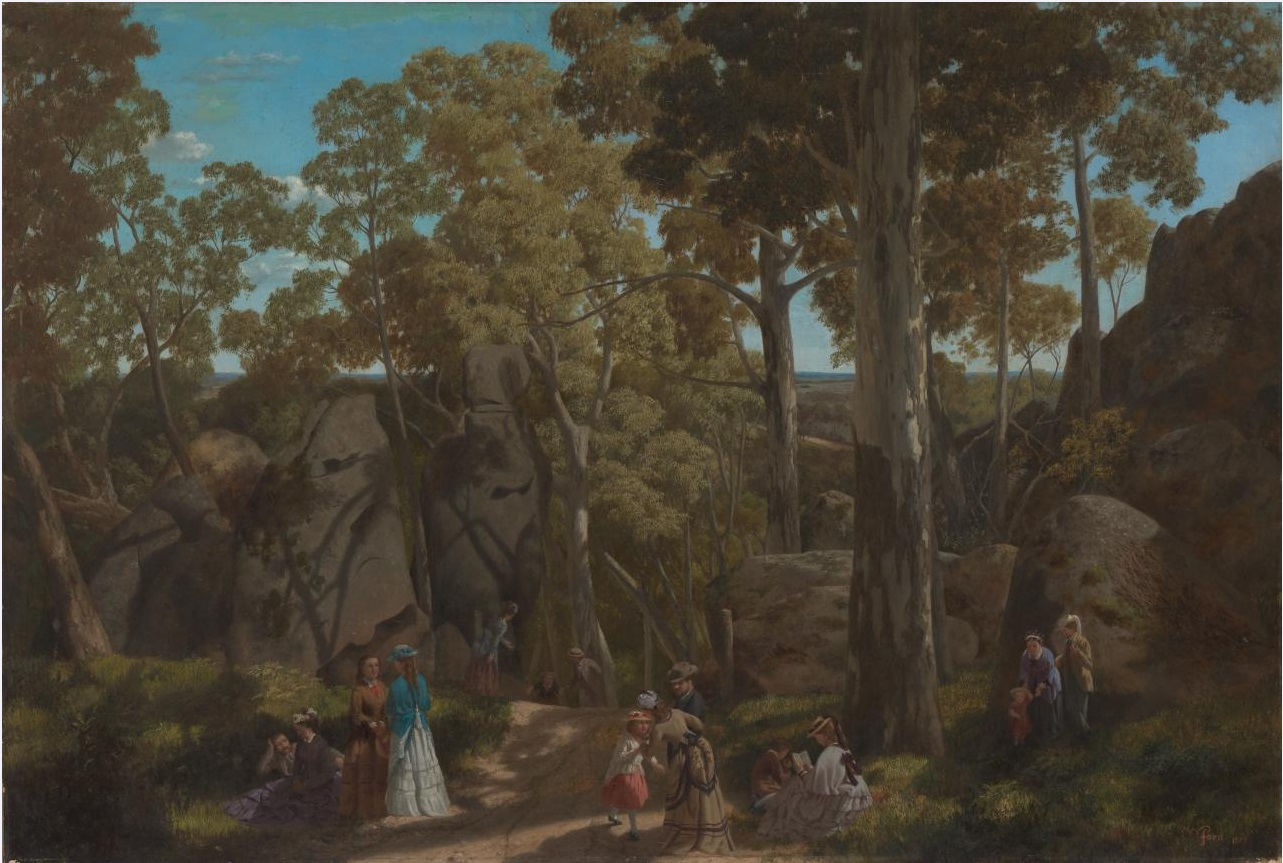

In [3]:
# image sourced from Wikidata.

display(Image(datum['image'], width=300, height=300))

In [4]:
# summary text sourced from Wikipedia.

if datum['article']:
    wikipedia_query = requests.get(f"https://en.wikipedia.org/api/rest_v1/page/summary/{pathlib.Path(datum['article']).name}")
    wikipedia_query = json.loads(wikipedia_query.text)
    print(wikipedia_query['extract'])

Picnic at Hanging Rock is a 1975 Australian mystery film produced by Hal and Jim McElroy, directed by Peter Weir, and starring Rachel Roberts, Dominic Guard, Helen Morse, Vivean Gray and Jacki Weaver. It was adapted by Cliff Green from the 1967 novel of the same name by Joan Lindsay.


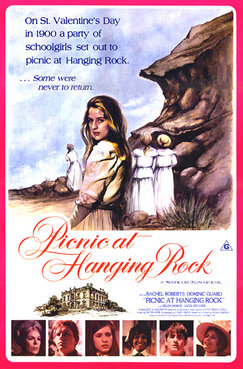

In [5]:
# image sourced from Wikipedia.

if datum['article']:
    wikipedia_query = requests.get(f"https://en.wikipedia.org/api/rest_v1/page/summary/{pathlib.Path(datum['article']).name}")
    wikipedia_query = json.loads(wikipedia_query.text)
    if pydash.get(wikipedia_query, 'thumbnail.source'):
        display(Image(pydash.get(wikipedia_query, 'thumbnail.source'), width=300, height=300))